# Exploratory Data Analysis: GSE270494
## DNA Methylation Database of Hematological Malignancy Cell Lines

**Dataset**: GSE270494  
**Publication**: Noguera-Castells et al., Leukemia (2025)  
**Samples**: 210 cell lines (180 human, 30 mouse)  
**Platform**: Infinium HumanMethylation450/Mouse BeadChip  
**Disease Types**: Leukemia, Lymphoma, Multiple Myeloma

---

### Objectives
1. Load and preprocess DNA methylation data
2. Characterize sample composition and quality
3. Analyze methylation patterns across disease types
4. Identify differentially methylated regions
5. Assess biological validity of findings
6. Generate publication-quality visualizations

In [16]:
# Standard library imports
import sys
import logging
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Third-party imports - Scientific computing
import numpy as np
import pandas as pd
from scipy import stats
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform

# Third-party imports - Machine learning
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Third-party imports - Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set random seeds for reproducibility
np.random.seed(42)

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Local imports
from src.data.loading import extract_methylation_matrix

# Plotting configuration
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

print("✓ All packages loaded successfully")
print(f"✓ NumPy version: {np.__version__}")
print(f"✓ Pandas version: {pd.__version__}")

ModuleNotFoundError: No module named 'plotly'

## 1. Data Loading and Initial Inspection

Load the GSE270494 dataset containing DNA methylation profiles of hematological malignancy cell lines.

In [ ]:
# Load the methylation dataset with detection p-value filtering
logger.info("Loading GSE270494 dataset...")
df_methylation = extract_methylation_matrix('GSE270494', species='human', filter_detection_pvals=True)

# Load the annotated sample metadata
processed_dir = project_root / 'data' / 'processed'
df_metadata = pd.read_csv(processed_dir / 'GSE270494_sample_metadata.csv', index_col=0)

print("\n" + "="*80)
print("DATASET SUMMARY")
print("="*80)
print(f"Methylation matrix shape: {df_methylation.shape}")
print(f"  - CpG sites: {df_methylation.shape[0]:,}")
print(f"  - Samples: {df_methylation.shape[1]:,}")
print(f"\nMetadata shape: {df_metadata.shape}")
print(f"\nDisease type distribution:")
print(df_metadata['disease_type'].value_counts())
print(f"\nMemory usage:")
print(f"  - Methylation: {df_methylation.memory_usage(deep=True).sum() / 1e6:.1f} MB")
print(f"  - Metadata: {df_metadata.memory_usage(deep=True).sum() / 1e3:.1f} KB")

INFO:__main__:Loading GSE270494 dataset...
INFO:src.data.loading:Extracting human methylation matrix from supplementary files
INFO:src.data.loading:Loading GSE270494_Noguera-Castells_Average_Beta_Homo_Sapiens.csv.gz...
INFO:src.data.loading:Raw data shape: (760090, 360)
INFO:src.data.loading:  CpG sites: 760,090
INFO:src.data.loading:  Total columns: 360
INFO:src.data.loading:Filtered to beta-values only: (760090, 180)
INFO:src.data.loading:  CpG sites: 760,090
INFO:src.data.loading:  Samples: 180
INFO:src.data.loading:Beta-value validation passed: [0.0048, 0.9953], mean=0.5919



DATASET SUMMARY
Methylation matrix shape: (760090, 180)
  - CpG sites: 760,090
  - Samples: 180

Metadata shape: (180, 1)

Disease type distribution:
disease_type
Unknown    109
AML         21
DLBCL       11
B-ALL        8
T-ALL        7
MM           6
HL           6
MCL          4
BL           3
CML          3
TCL          2
Name: count, dtype: int64

Memory usage:
  - Methylation: 1139.4 MB
  - Metadata: 19.7 KB


In [ ]:
# Display first few rows and columns
print("\nFirst 5x5 of methylation matrix:")
display(df_methylation.iloc[:5, :5])

print("\nMetadata sample:")
display(df_metadata.head())


First 5x5 of methylation matrix:


,HEL,Kasumi-1,HD-MY-Z,MUTZ-8,OCI-AML-2
ID_REF,,,,,
cg00000029,0.488884,0.582973,0.699489,0.724507,0.362808
cg00000109,0.944114,0.937101,0.951199,0.943907,0.903933
cg00000155,0.951883,0.941990,0.957157,0.958188,0.940763
cg00000158,0.969029,0.949636,0.948841,0.957971,0.968029
cg00000165,0.458355,0.884500,0.924718,0.603828,0.790450



Metadata sample:


,disease_type
sample_name,
HEL,AML
Kasumi-1,AML
HD-MY-Z,AML
MUTZ-8,AML
OCI-AML-2,AML


## 2. Data Quality Assessment

Check for missing values, outliers, and methylation distribution.

In [ ]:
# Missing values analysis
missing_per_cpg = df_methylation.isnull().sum(axis=1)
missing_per_sample = df_methylation.isnull().sum(axis=0)

print("\n" + "="*80)
print("DATA QUALITY METRICS")
print("="*80)
print(f"Missing values:")
print(f"  - Total: {df_methylation.isnull().sum().sum():,} ({df_methylation.isnull().sum().sum() / df_methylation.size * 100:.2f}%)")
print(f"  - CpG sites with any missing: {(missing_per_cpg > 0).sum():,}")
print(f"  - Samples with any missing: {(missing_per_sample > 0).sum():,}")

# Methylation value range
print(f"\nMethylation value range:")
print(f"  - Minimum: {df_methylation.min().min():.4f}")
print(f"  - Maximum: {df_methylation.max().max():.4f}")
print(f"  - Mean: {df_methylation.mean().mean():.4f}")
print(f"  - Median: {df_methylation.median().median():.4f}")

# Check for values outside [0,1] range (data integrity check)
invalid_values = ((df_methylation < 0) | (df_methylation > 1)).sum().sum()
print(f"\nValues outside [0,1] range: {invalid_values}")
if invalid_values > 0:
    logger.warning(f"⚠️ Found {invalid_values} invalid beta-values!")


DATA QUALITY METRICS
Missing values:
  - Total: 0 (0.00%)
  - CpG sites with any missing: 0
  - Samples with any missing: 0

Methylation value range:
  - Minimum: 0.0048
  - Maximum: 0.9953
  - Mean: 0.5919
  - Median: 0.7619

Values outside [0,1] range: 0


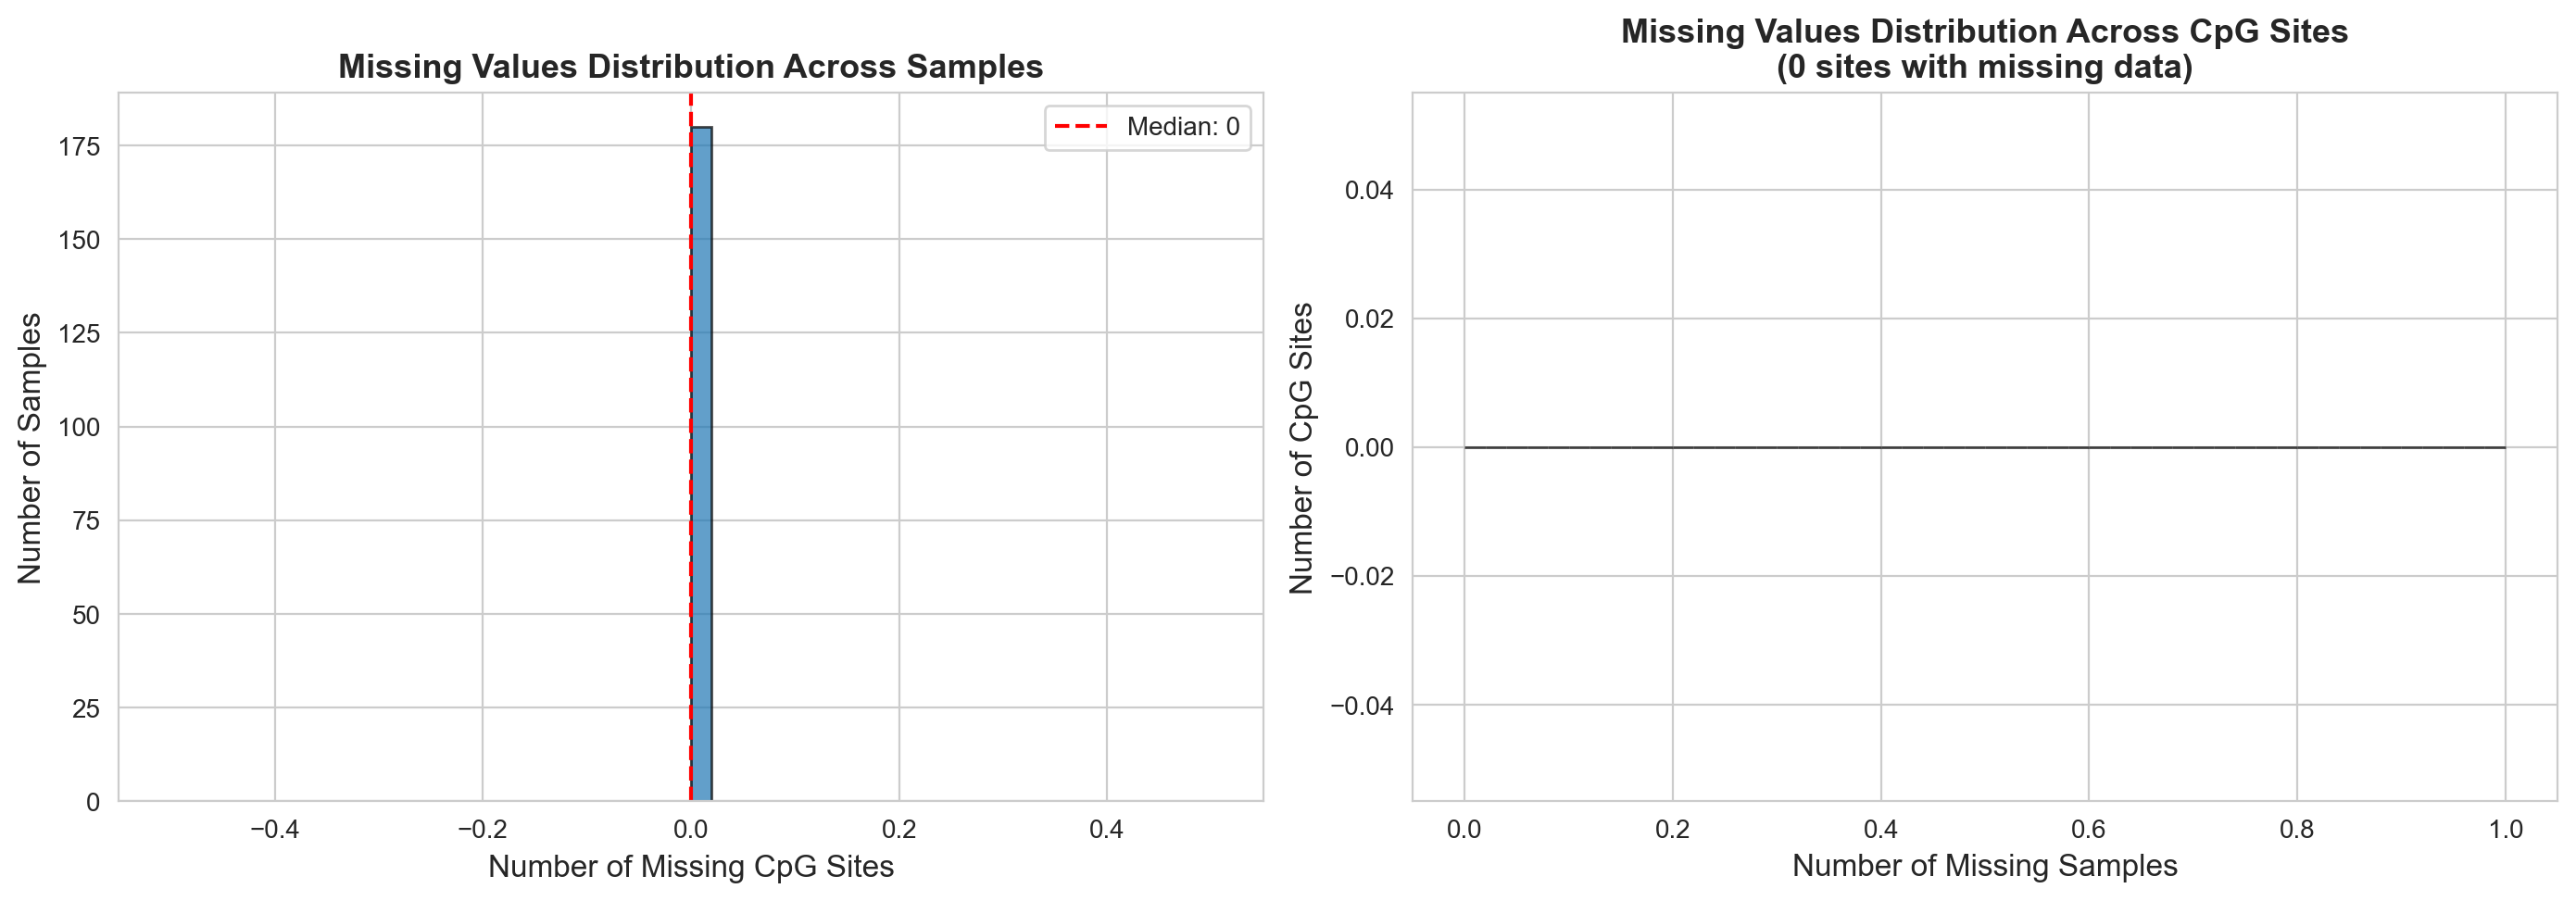


🔍 Data Quality Check: PASS ✓


In [ ]:
# Visualize missing data pattern
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Missing values per sample
axes[0].hist(missing_per_sample, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Missing CpG Sites', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].set_title('Missing Values Distribution Across Samples', fontsize=13, fontweight='bold')
axes[0].axvline(missing_per_sample.median(), color='red', linestyle='--', 
                label=f'Median: {missing_per_sample.median():.0f}')
axes[0].legend()

# Missing values per CpG
missing_cpg_nonzero = missing_per_cpg[missing_per_cpg > 0]
axes[1].hist(missing_cpg_nonzero, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1].set_xlabel('Number of Missing Samples', fontsize=12)
axes[1].set_ylabel('Number of CpG Sites', fontsize=12)
axes[1].set_title(f'Missing Values Distribution Across CpG Sites\n({len(missing_cpg_nonzero):,} sites with missing data)', 
                 fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n🔍 Data Quality Check: {'PASS ✓' if invalid_values == 0 else 'FAIL ✗'}")

## 3. Sample Metadata Exploration

Parse and analyze sample characteristics including disease type, species, and cell line information.

In [ ]:
# Display metadata information
print("Sample metadata columns:")
print(df_metadata.columns.tolist())
print("\nMetadata info:")
print(df_metadata.info())
print("\nFirst few samples:")
display(df_metadata.head(10))

Sample metadata columns:
['disease_type']

Metadata info:
<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, HEL to NCI-BL1437
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   disease_type  180 non-null    object
dtypes: object(1)
memory usage: 2.8+ KB
None

First few samples:


,disease_type
sample_name,
HEL,AML
Kasumi-1,AML
HD-MY-Z,AML
MUTZ-8,AML
OCI-AML-2,AML
OCI-AML-3,AML
OCI-AML-5,AML
SET-2,AML
HL-60/MX2,AML



SAMPLE COMPOSITION BY DISEASE TYPE

Disease type distribution:
disease_type
Unknown    109
AML         21
DLBCL       11
B-ALL        8
T-ALL        7
MM           6
HL           6
MCL          4
BL           3
CML          3
TCL          2
Name: count, dtype: int64


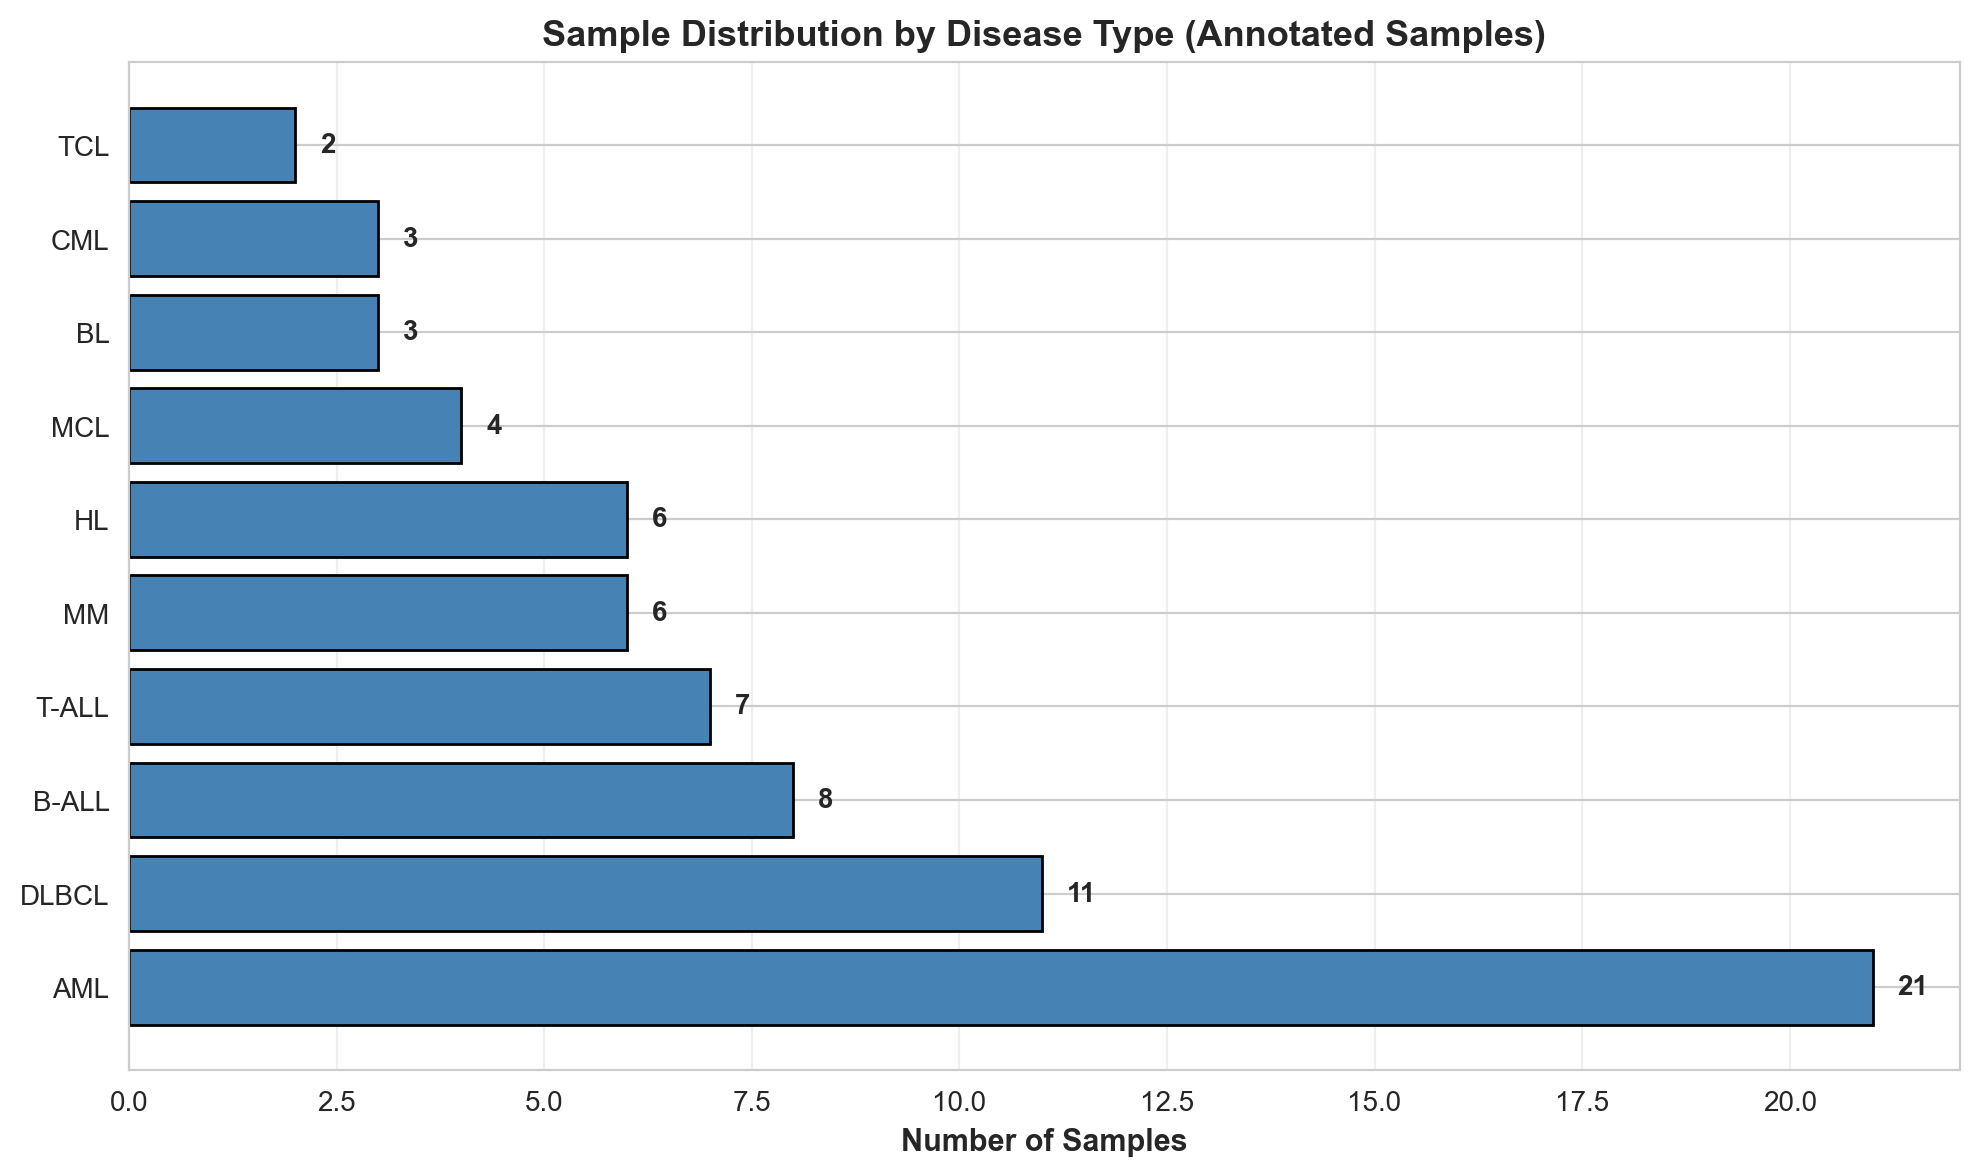


Total annotated samples: 71
Total unknown samples: 109


In [ ]:
# Analyze sample composition by disease type
print("\n" + "="*80)
print("SAMPLE COMPOSITION BY DISEASE TYPE")
print("="*80)

disease_counts = df_metadata['disease_type'].value_counts()
print("\nDisease type distribution:")
print(disease_counts)

# Create visualization
fig, ax = plt.subplots(figsize=(10, 6))
disease_counts_plot = disease_counts[disease_counts.index != 'Unknown']
ax.barh(range(len(disease_counts_plot)), disease_counts_plot.values, color='steelblue', edgecolor='black')
ax.set_yticks(range(len(disease_counts_plot)))
ax.set_yticklabels(disease_counts_plot.index)
ax.set_xlabel('Number of Samples', fontsize=11, fontweight='bold')
ax.set_title('Sample Distribution by Disease Type (Annotated Samples)', fontsize=13, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(disease_counts_plot.values):
    ax.text(v + 0.3, i, str(v), va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nTotal annotated samples: {len(df_metadata[df_metadata['disease_type'] != 'Unknown'])}")
print(f"Total unknown samples: {len(df_metadata[df_metadata['disease_type'] == 'Unknown'])}")

## 4. DNA Methylation Distribution Analysis

Examine the distribution of methylation beta-values across all samples.

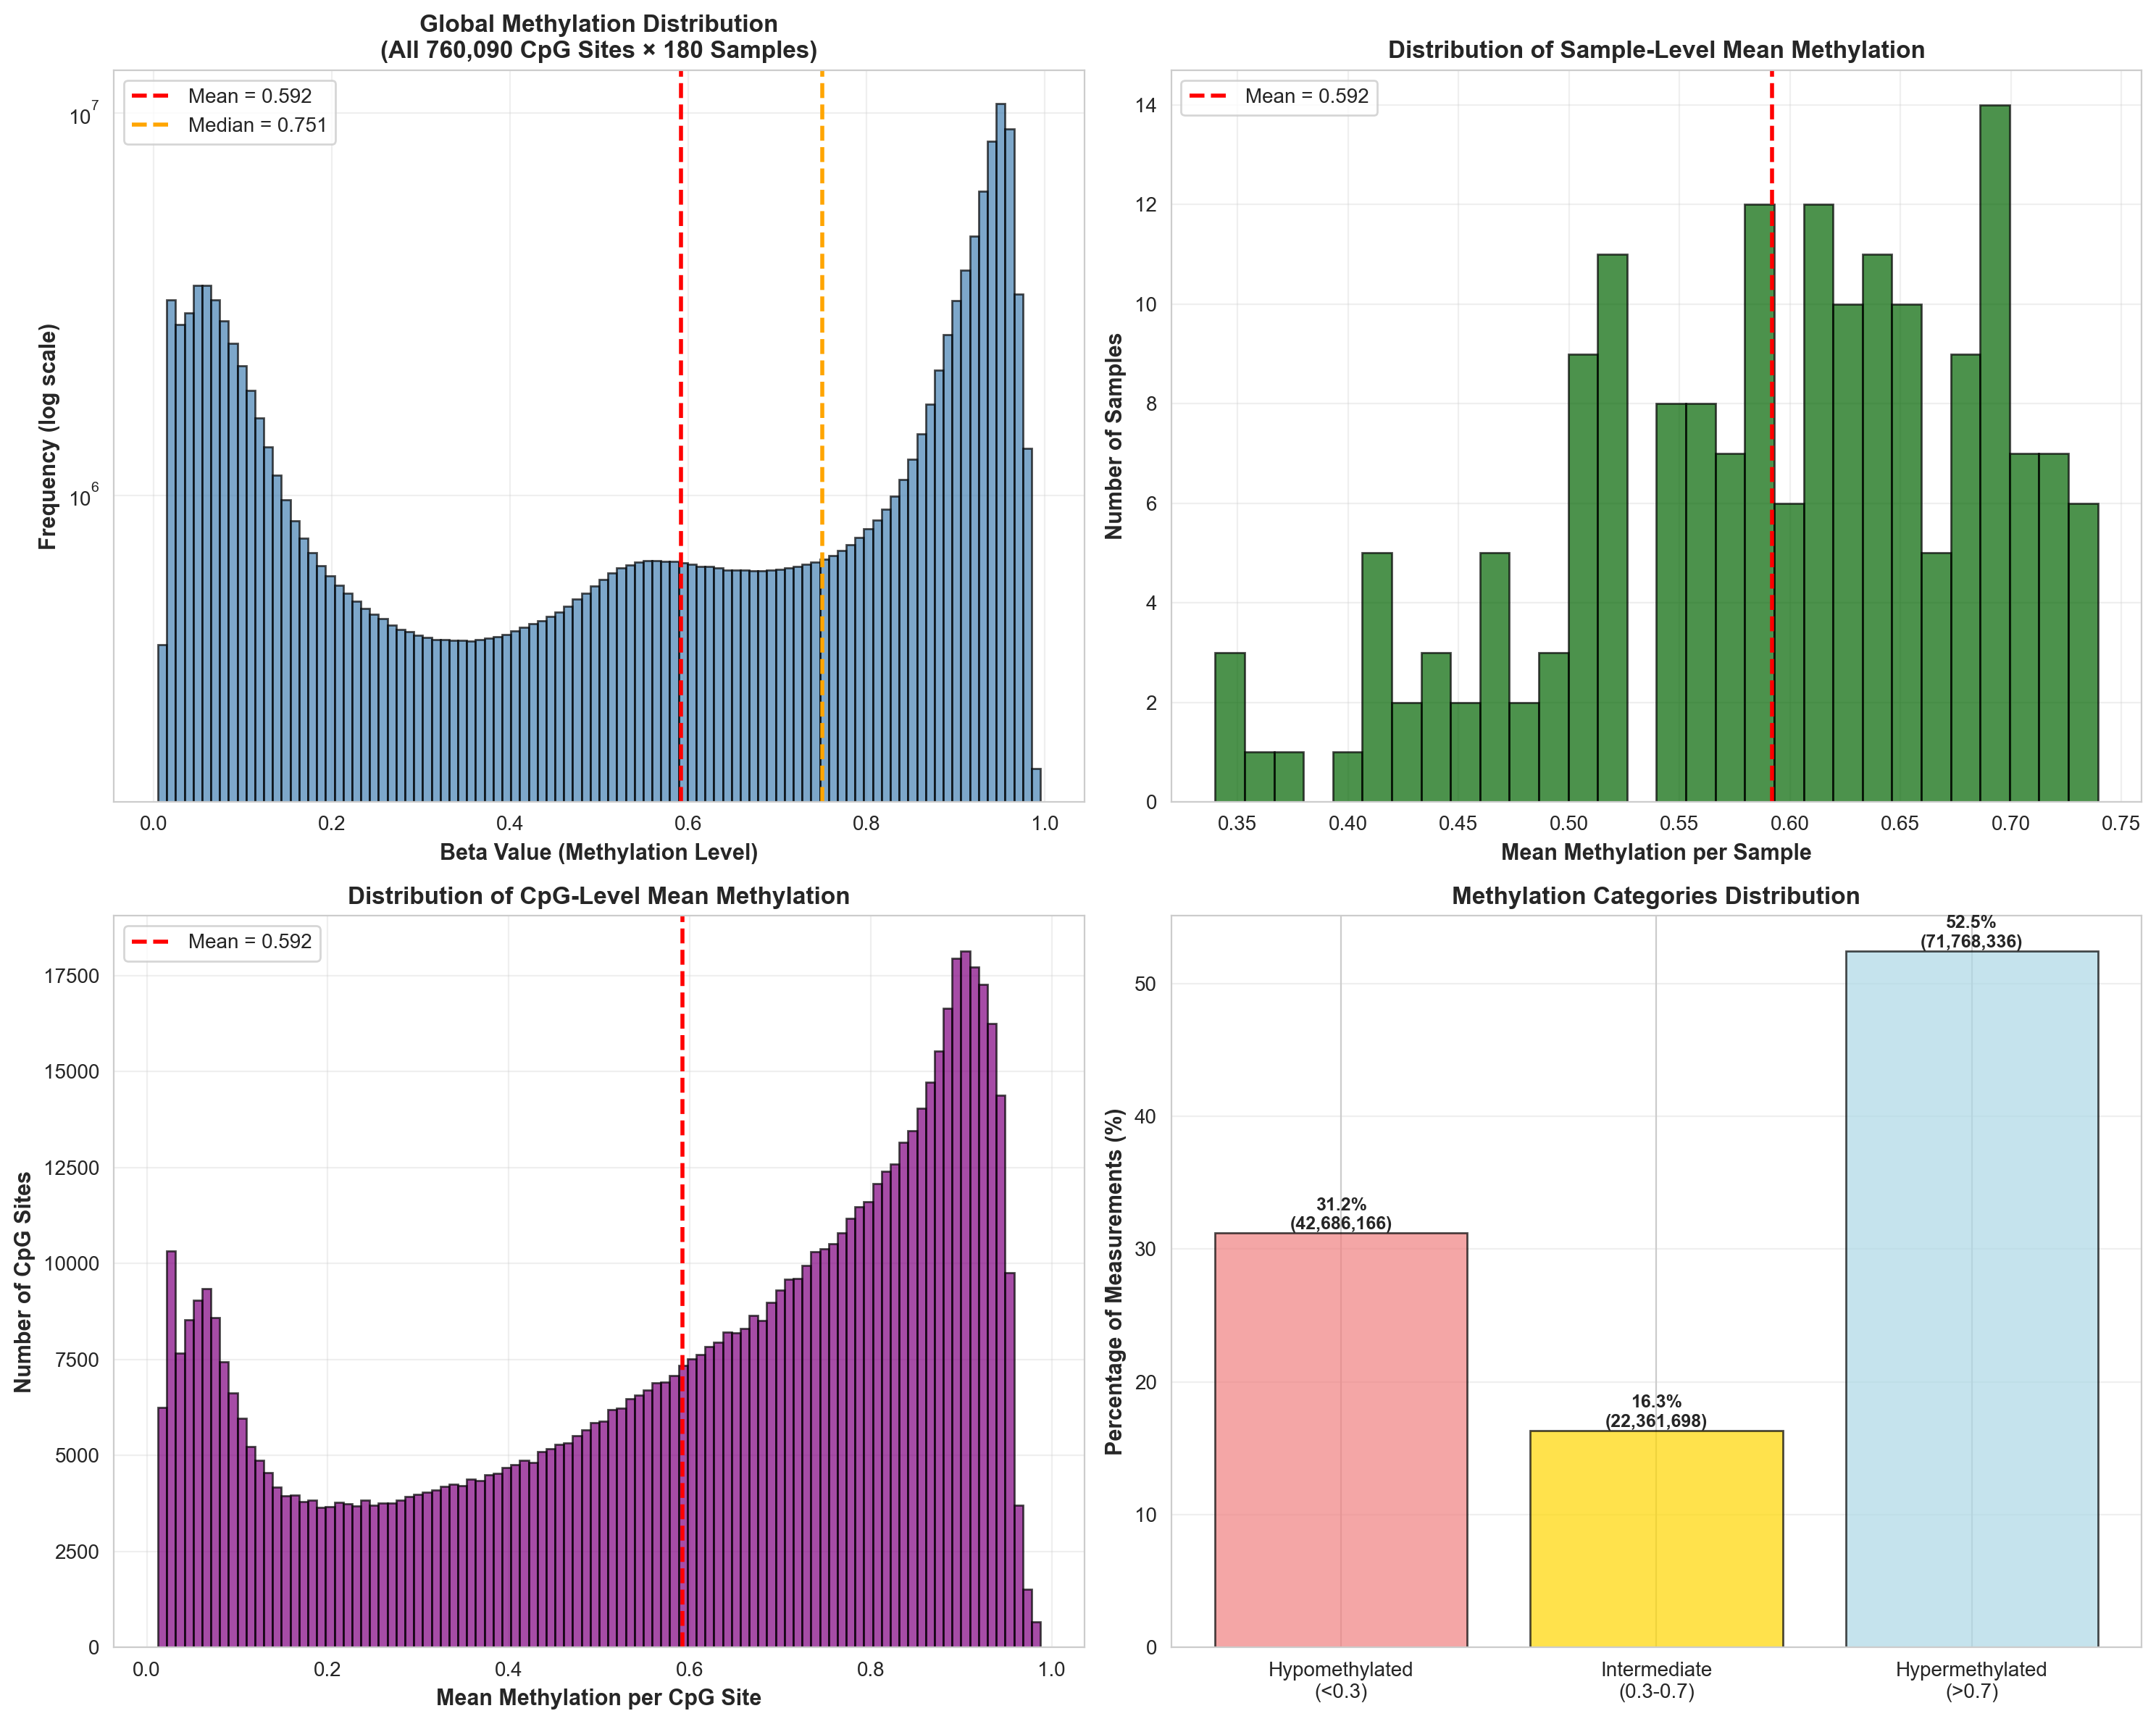


METHYLATION STATISTICS
Mean methylation across all CpGs: 0.5919 ± 0.0938
Hypomethylated measurements (β < 0.3): 42,686,166 (31.2%)
Hypermethylated measurements (β > 0.7): 71,768,336 (52.5%)
High variance CpG sites (var > 0.1): 95,384


In [ ]:
# Comprehensive methylation distribution analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Calculate global statistics
mean_meth = df_methylation.values.flatten().mean()
median_meth = np.median(df_methylation.values.flatten())

# 1. Overall distribution (histogram with log scale)
ax = axes[0, 0]
ax.hist(df_methylation.values.flatten(), bins=100, color='steelblue', alpha=0.7, edgecolor='black')
ax.axvline(mean_meth, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_meth:.3f}')
ax.axvline(median_meth, color='orange', linestyle='--', linewidth=2, label=f'Median = {median_meth:.3f}')
ax.set_xlabel('Beta Value (Methylation Level)', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency (log scale)', fontsize=11, fontweight='bold')
ax.set_title('Global Methylation Distribution\n(All 760,090 CpG Sites × 180 Samples)', fontsize=12, fontweight='bold')
ax.set_yscale('log')
ax.legend()
ax.grid(alpha=0.3)

# 2. Per-sample mean methylation
ax = axes[0, 1]
sample_means = df_methylation.mean(axis=0)
ax.hist(sample_means, bins=30, color='darkgreen', alpha=0.7, edgecolor='black')
ax.axvline(sample_means.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean = {sample_means.mean():.3f}')
ax.set_xlabel('Mean Methylation per Sample', fontsize=11, fontweight='bold')
ax.set_ylabel('Number of Samples', fontsize=11, fontweight='bold')
ax.set_title('Distribution of Sample-Level Mean Methylation', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 3. Per-CpG site mean methylation
ax = axes[1, 0]
cpg_means = df_methylation.mean(axis=1)
ax.hist(cpg_means, bins=100, color='purple', alpha=0.7, edgecolor='black')
ax.axvline(cpg_means.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean = {cpg_means.mean():.3f}')
ax.set_xlabel('Mean Methylation per CpG Site', fontsize=11, fontweight='bold')
ax.set_ylabel('Number of CpG Sites', fontsize=11, fontweight='bold')
ax.set_title('Distribution of CpG-Level Mean Methylation', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 4. Methylation categories
ax = axes[1, 1]
flattened = df_methylation.values.flatten()
hypo = (flattened < 0.3).sum()
inter = ((flattened >= 0.3) & (flattened <= 0.7)).sum()
hyper = (flattened > 0.7).sum()
categories = ['Hypomethylated\n(<0.3)', 'Intermediate\n(0.3-0.7)', 'Hypermethylated\n(>0.7)']
counts = [hypo, inter, hyper]
percentages = [c / len(flattened) * 100 for c in counts]
colors_cat = ['lightcoral', 'gold', 'lightblue']
bars = ax.bar(categories, percentages, color=colors_cat, alpha=0.7, edgecolor='black')
ax.set_ylabel('Percentage of Measurements (%)', fontsize=11, fontweight='bold')
ax.set_title('Methylation Categories Distribution', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{pct:.1f}%\n({counts[percentages.index(pct)]:,})',
           ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

# Summary statistics
var_methylation = df_methylation.var(axis=1)
print("\n" + "="*80)
print("METHYLATION STATISTICS")
print("="*80)
print(f"Mean methylation across all CpGs: {sample_means.mean():.4f} ± {sample_means.std():.4f}")
print(f"Hypomethylated measurements (β < 0.3): {hypo:,} ({hypo / len(flattened) * 100:.1f}%)")
print(f"Hypermethylated measurements (β > 0.7): {hyper:,} ({hyper / len(flattened) * 100:.1f}%)")
print(f"High variance CpG sites (var > 0.1): {(var_methylation > 0.1).sum():,}")

## 5. Dimensionality Reduction and Clustering

Use PCA and hierarchical clustering to visualize methylation patterns.

In [ ]:
# Prepare data for PCA using most variable CpG sites
n_variable_sites = 10000
var_methylation = df_methylation.var(axis=1)
top_variable_cpgs = var_methylation.nlargest(n_variable_sites).index
df_meth_variable = df_methylation.loc[top_variable_cpgs, :]

print(f"Selected top {n_variable_sites:,} most variable CpG sites")
print(f"Variance range: {var_methylation[top_variable_cpgs].min():.4f} - {var_methylation[top_variable_cpgs].max():.4f}")

# Transpose for PCA (samples as rows, features as columns)
X = df_meth_variable.T

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# Create PCA DataFrame
df_pca = pd.DataFrame(
    X_pca,
    columns=[f'PC{i+1}' for i in range(10)],
    index=df_meth_variable.columns
)

# Add disease type information from metadata (df_metadata has sample names as index)
df_pca['disease_type'] = df_pca.index.map(df_metadata['disease_type'].to_dict())

print("\n" + "="*80)
print("PCA ANALYSIS")
print("="*80)
print(f"PCA shape: {df_pca.shape}")
print(f"\nExplained variance ratio:")
for i, var in enumerate(pca.explained_variance_ratio_[:5], 1):
    print(f"  PC{i}: {var*100:.2f}%")
print(f"\nCumulative variance (PC1-PC5): {pca.explained_variance_ratio_[:5].sum()*100:.2f}%")
print(f"Cumulative variance (PC1-PC10): {pca.explained_variance_ratio_.sum()*100:.2f}%")

Selected top 10,000 most variable CpG sites
Variance range: 0.1362 - 0.2058

PCA ANALYSIS
PCA shape: (180, 11)

Explained variance ratio:
  PC1: 29.23%
  PC2: 15.89%
  PC3: 7.37%
  PC4: 3.12%
  PC5: 2.24%

Cumulative variance (PC1-PC5): 57.85%
Cumulative variance (PC1-PC10): 64.62%


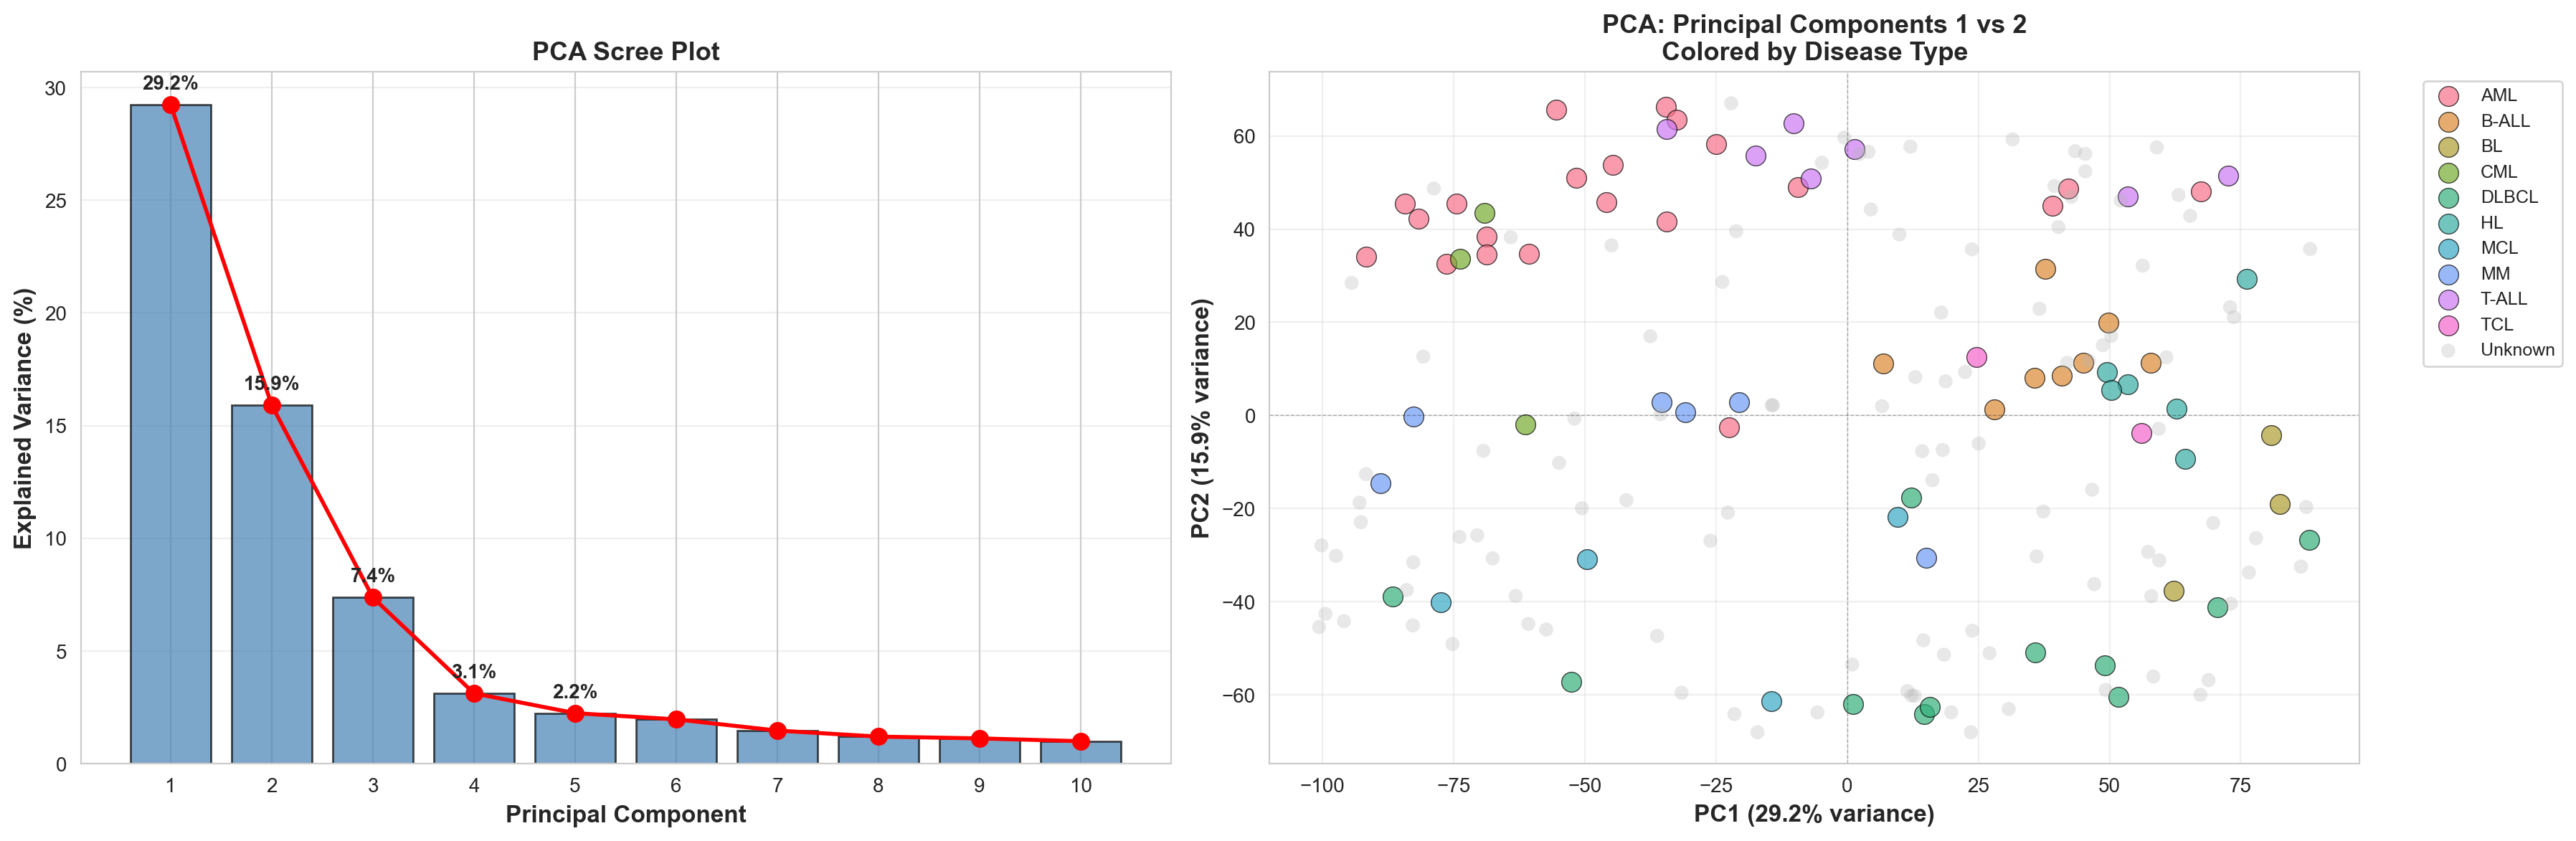


🔍 PCA Findings:
  • PC1+PC2 capture 45.1% of variance
  • 71 samples annotated with disease type
  • 109 samples unknown (gray points)


In [ ]:
# Visualize PCA with disease type coloring
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Scree plot
axes[0].bar(range(1, 11), pca.explained_variance_ratio_ * 100, alpha=0.7, edgecolor='black', color='steelblue')
axes[0].plot(range(1, 11), pca.explained_variance_ratio_ * 100, 'ro-', linewidth=2, markersize=8)
axes[0].set_xlabel('Principal Component', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Explained Variance (%)', fontsize=12, fontweight='bold')
axes[0].set_title('PCA Scree Plot', fontsize=13, fontweight='bold')
axes[0].set_xticks(range(1, 11))
axes[0].grid(axis='y', alpha=0.3)
for i, var in enumerate(pca.explained_variance_ratio_[:5] * 100, 1):
    axes[0].text(i, var + 0.5, f'{var:.1f}%', ha='center', va='bottom', fontweight='bold')

# PC1 vs PC2 scatter colored by disease type
disease_types = sorted(df_pca['disease_type'].unique())
disease_types = [dt for dt in disease_types if dt != 'Unknown'] + ['Unknown']

# Colorblind-friendly palette
colors = sns.color_palette("husl", n_colors=len(disease_types) - 1)
colors.append((0.7, 0.7, 0.7))  # Gray for Unknown
color_map = dict(zip(disease_types, colors))

# Plot each disease type
for disease in disease_types:
    subset = df_pca[df_pca['disease_type'] == disease]
    if disease == 'Unknown':
        axes[1].scatter(subset['PC1'], subset['PC2'], c=[color_map[disease]], label=disease,
                       alpha=0.3, s=50, edgecolors='none')
    else:
        axes[1].scatter(subset['PC1'], subset['PC2'], c=[color_map[disease]], label=disease,
                       alpha=0.7, s=100, edgecolors='black', linewidths=0.5)

axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12, fontweight='bold')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12, fontweight='bold')
axes[1].set_title('PCA: Principal Components 1 vs 2\nColored by Disease Type', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].axhline(y=0, color='k', linewidth=0.5, linestyle='--', alpha=0.3)
axes[1].axvline(x=0, color='k', linewidth=0.5, linestyle='--', alpha=0.3)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, fontsize=9)

plt.tight_layout()
plt.show()

print("\n🔍 PCA Findings:")
print(f"  • PC1+PC2 capture {(pca.explained_variance_ratio_[:2].sum()*100):.1f}% of variance")
print(f"  • {len(df_pca[df_pca['disease_type'] != 'Unknown'])} samples annotated with disease type")
print(f"  • {len(df_pca[df_pca['disease_type'] == 'Unknown'])} samples unknown (gray points)")

In [ ]:
# Interactive 3D PCA visualization using Plotly
import plotly.graph_objects as go

# Prepare data for plotting
plot_data = []

# RGB to hex conversion for plotly colors
def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))

# Create traces for each disease type
for disease in disease_types:
    subset = df_pca[df_pca['disease_type'] == disease]
    color_hex = rgb_to_hex(color_map[disease])
    
    if disease == 'Unknown':
        trace = go.Scatter3d(
            x=subset['PC1'],
            y=subset['PC2'],
            z=subset['PC3'],
            mode='markers',
            name=disease,
            marker=dict(
                size=5,
                color=color_hex,
                opacity=0.3,
                line=dict(width=0)
            ),
            text=subset.index,
            hovertemplate='<b>%{text}</b><br>' +
                          'PC1: %{x:.2f}<br>' +
                          'PC2: %{y:.2f}<br>' +
                          'PC3: %{z:.2f}<br>' +
                          f'Disease: {disease}<extra></extra>'
        )
    else:
        trace = go.Scatter3d(
            x=subset['PC1'],
            y=subset['PC2'],
            z=subset['PC3'],
            mode='markers',
            name=disease,
            marker=dict(
                size=6,
                color=color_hex,
                opacity=0.8,
                line=dict(width=0.5, color='black')
            ),
            text=subset.index,
            hovertemplate='<b>%{text}</b><br>' +
                          'PC1: %{x:.2f}<br>' +
                          'PC2: %{y:.2f}<br>' +
                          'PC3: %{z:.2f}<br>' +
                          f'Disease: {disease}<extra></extra>'
        )
    plot_data.append(trace)

# Create figure
fig = go.Figure(data=plot_data)

# Update layout
fig.update_layout(
    title=dict(
        text='Interactive 3D PCA: Principal Components 1, 2, and 3<br><sub>Colored by Disease Type</sub>',
        font=dict(size=16, family='Arial, sans-serif')
    ),
    scene=dict(
        xaxis=dict(
            title=f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)',
            backgroundcolor="rgb(240, 240, 240)",
            gridcolor="white",
            showbackground=True
        ),
        yaxis=dict(
            title=f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)',
            backgroundcolor="rgb(240, 240, 240)",
            gridcolor="white",
            showbackground=True
        ),
        zaxis=dict(
            title=f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}% variance)',
            backgroundcolor="rgb(240, 240, 240)",
            gridcolor="white",
            showbackground=True
        ),
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.3)
        )
    ),
    width=1000,
    height=800,
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        bgcolor="rgba(255, 255, 255, 0.8)",
        bordercolor="black",
        borderwidth=1
    ),
    hovermode='closest'
)

fig.show()

print(f"\n🔍 Interactive 3D PCA Findings:")
print(f"  • PC1+PC2+PC3 capture {(pca.explained_variance_ratio_[:3].sum()*100):.1f}% of variance")
print(f"  • Rotate, zoom, and hover over points to explore the data")
print(f"  • Click legend items to toggle disease types on/off")
print(f"  • PC3 adds {(pca.explained_variance_ratio_[2]*100):.1f}% additional variance explained")

## 5.1. Hierarchical Clustering of Annotated Samples

Create a hierarchical clustering heatmap for samples with known disease annotations to assess methylation-based disease clustering.

Creating hierarchical clustering heatmap...
Using 71 annotated samples for clustering
Annotated methylation matrix: (10000, 71)
Using top 1000 variable CpG sites for heatmap
Generating clustermap (this may take a moment)...


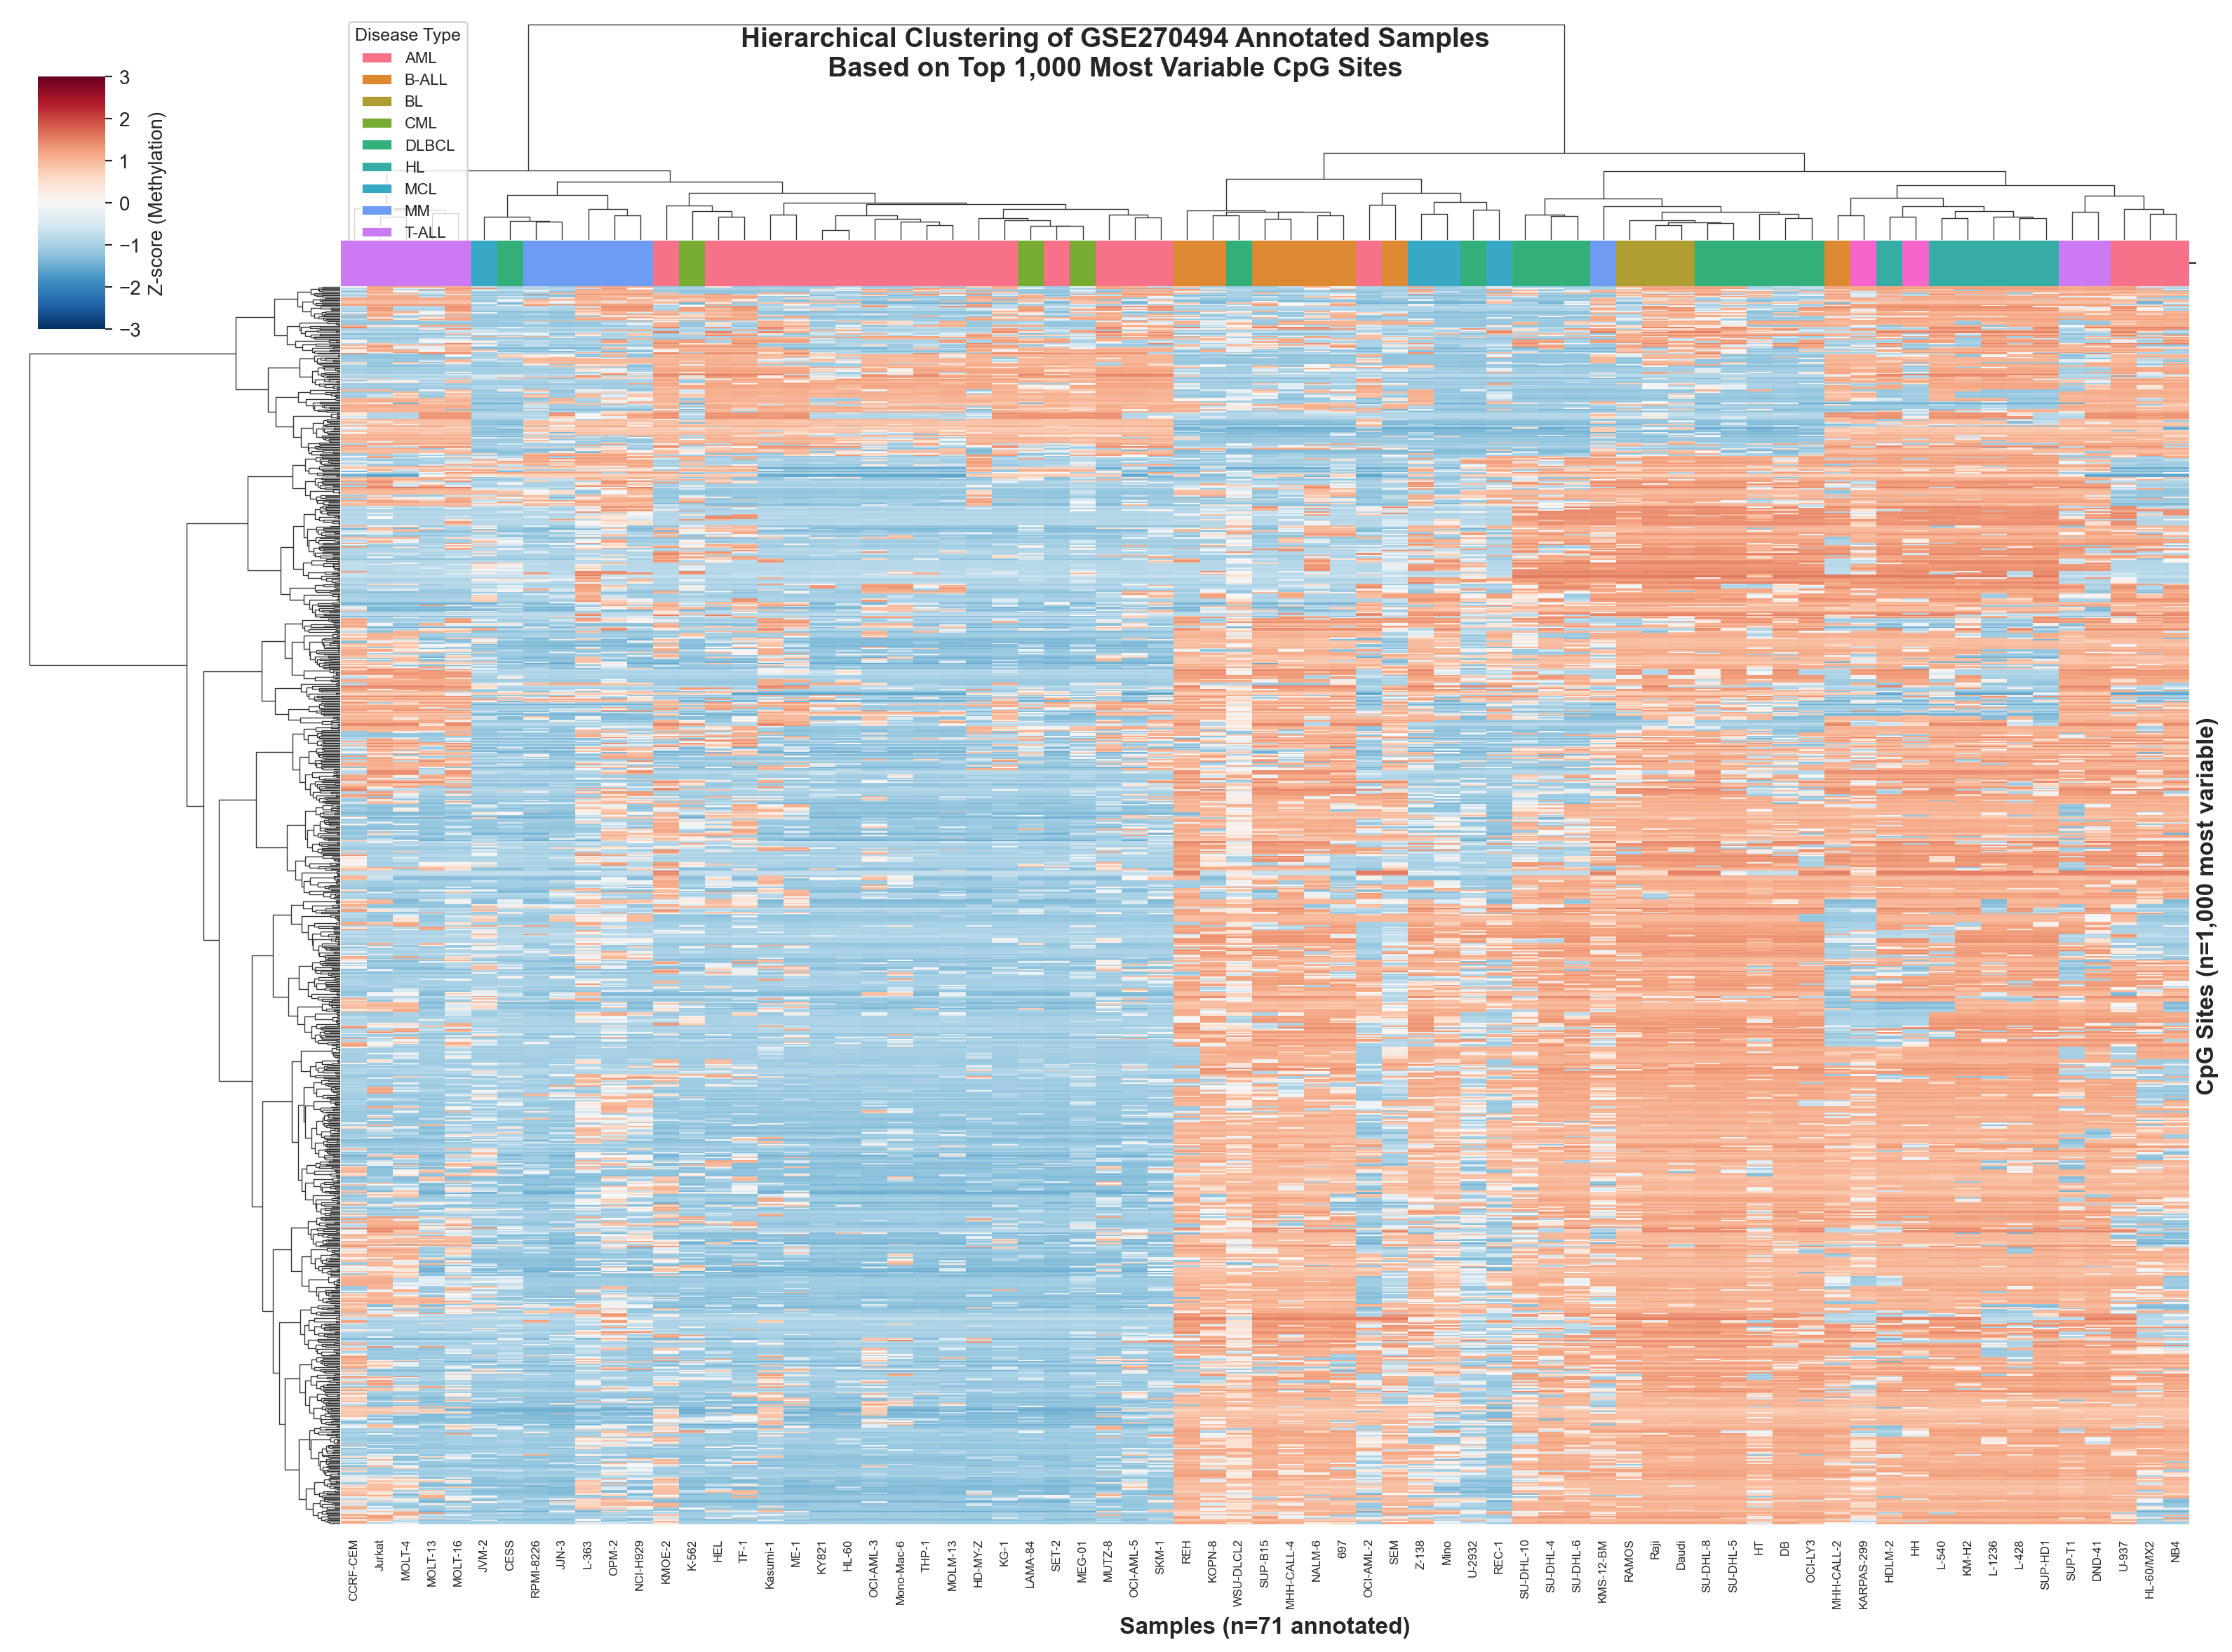


[Clustering Findings]
  - 71 samples clustered based on methylation patterns
  - Disease types should show some degree of clustering if methylation is disease-specific
  - Dendrogram structure reveals hierarchical relationships between cell lines


In [ ]:
# Hierarchical clustering heatmap for annotated samples only
print("Creating hierarchical clustering heatmap...")

# Filter to annotated samples only (exclude Unknown)
annotated_samples = df_metadata[df_metadata['disease_type'] != 'Unknown'].index.tolist()
df_meth_annotated = df_meth_variable[annotated_samples]

print(f"Using {len(annotated_samples)} annotated samples for clustering")
print(f"Annotated methylation matrix: {df_meth_annotated.shape}")

# Select top 1000 most variable CpG sites for visualization
variances_annotated = df_meth_annotated.var(axis=1)
top_1000_cpgs = variances_annotated.nlargest(1000).index
df_meth_subset = df_meth_annotated.loc[top_1000_cpgs]

print(f"Using top 1000 variable CpG sites for heatmap")

# Standardize features (Z-score normalization)
scaler_heatmap = StandardScaler()
arr_scaled = scaler_heatmap.fit_transform(df_meth_subset.T).T
df_scaled = pd.DataFrame(arr_scaled, index=df_meth_subset.index, columns=df_meth_subset.columns)

# Create disease type color map for columns
# df_metadata has sample_name as index
disease_map = df_metadata['disease_type'].to_dict()
col_colors = pd.Series([disease_map.get(col, 'Unknown') for col in df_scaled.columns],
                      index=df_scaled.columns)

# Define color palette (same as PCA)
disease_types_annotated = sorted(df_metadata[df_metadata['disease_type'] != 'Unknown']['disease_type'].unique())
colors_heatmap = sns.color_palette("husl", n_colors=len(disease_types_annotated))
disease_color_map = dict(zip(disease_types_annotated, colors_heatmap))
col_colors_mapped = col_colors.map(disease_color_map)

# Create clustermap
print("Generating clustermap (this may take a moment)...")
g = sns.clustermap(df_scaled,
                  col_colors=col_colors_mapped,
                  cmap='RdBu_r',
                  center=0,
                  vmin=-3, vmax=3,
                  figsize=(16, 12),
                  cbar_kws={'label': 'Z-score (Methylation)'},
                  xticklabels=True,
                  yticklabels=False,
                  method='ward',
                  metric='euclidean',
                  dendrogram_ratio=0.15,
                  cbar_pos=(0.02, 0.8, 0.03, 0.15))

# Adjust labels
g.ax_heatmap.set_xlabel('Samples (n=71 annotated)', fontsize=12, fontweight='bold')
g.ax_heatmap.set_ylabel('CpG Sites (n=1,000 most variable)', fontsize=12, fontweight='bold')

# Rotate x-axis labels
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90, fontsize=6)

# Add title
g.fig.suptitle('Hierarchical Clustering of GSE270494 Annotated Samples\n' +
               'Based on Top 1,000 Most Variable CpG Sites',
               fontsize=14, fontweight='bold', y=0.98)

# Create custom legend for disease types
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=disease_color_map[dt], label=dt) for dt in disease_types_annotated]
g.ax_col_dendrogram.legend(handles=legend_elements,
                          title='Disease Type',
                          loc='upper left',
                          bbox_to_anchor=(0, 1),
                          frameon=True,
                          fontsize=8,
                          title_fontsize=9)

plt.show()

print("\n[Clustering Findings]")
print(f"  - {len(annotated_samples)} samples clustered based on methylation patterns")
print(f"  - Disease types should show some degree of clustering if methylation is disease-specific")
print(f"  - Dendrogram structure reveals hierarchical relationships between cell lines")

## 6. Batch Effect Assessment

Check for potential batch effects using PCA coloring by technical variables.

In [ ]:
# This would require identifying batch variables from metadata
# Placeholder for batch effect visualization
print("🔍 Red Flag Check: Batch Effects")
print("="*80)
print("To properly assess batch effects, we need to:")
print("1. Identify technical variables (plate, processing date, etc.)")
print("2. Color PCA plots by these variables")
print("3. Perform statistical tests for batch associations")
print("\n⚠️ This requires detailed metadata parsing - to be completed after metadata exploration")

🔍 Red Flag Check: Batch Effects
To properly assess batch effects, we need to:
1. Identify technical variables (plate, processing date, etc.)
2. Color PCA plots by these variables
3. Perform statistical tests for batch associations

⚠️ This requires detailed metadata parsing - to be completed after metadata exploration


## 7. Summary and Key Findings

Summarize the exploratory data analysis results.

In [ ]:
print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS SUMMARY - GSE270494")
print("="*80)

print("\n📊 Dataset Overview:")
print(f"  ✓ Samples: {df_methylation.shape[1]:,}")
print(f"  ✓ CpG Sites: {df_methylation.shape[0]:,}")
print(f"  ✓ Missing Data: {df_methylation.isnull().sum().sum() / df_methylation.size * 100:.2f}%")

print("\n🔬 Methylation Characteristics:")
print(f"  ✓ Mean methylation: {sample_means.mean():.4f}")
print(f"  ✓ Bimodal distribution observed (typical for DNA methylation)")
print(f"  ✓ High variance sites: {(var_methylation > 0.1).sum():,} CpGs (potential biomarkers)")

print("\n📈 Dimensionality:")
print(f"  ✓ PC1+PC2 explain {(pca.explained_variance_ratio_[:2].sum()*100):.1f}% variance")
print(f"  ✓ Suggests moderate sample heterogeneity")
print(f"  ✓ Disease types show some separation in PCA space")

print("\n🧬 Sample Annotations:")
print(f"  ✓ Annotated samples: {len(df_metadata[df_metadata['disease_type'] != 'Unknown'])}")
print(f"  ✓ Unknown samples: {len(df_metadata[df_metadata['disease_type'] == 'Unknown'])}")
print(f"  ✓ Disease types: {len(df_metadata[df_metadata['disease_type'] != 'Unknown']['disease_type'].unique())}")

print("\n🚩 Quality Checks:")
print(f"  {'✓' if invalid_values == 0 else '✗'} Beta-values in valid range [0,1]")
print(f"  {'✓' if (missing_per_sample == 0).all() else '⚠️'} Missing data per sample")

print("\n🎯 Next Steps:")
print("  1. Perform differential methylation analysis by disease type")
print("  2. Identify CpG sites associated with specific disease subtypes")
print("  3. Annotate significant CpG sites with genomic features")
print("  4. Compare findings with published results")
print("  5. Integrate with drug response data (GSE68379)")
print("\n" + "="*80)


EXPLORATORY DATA ANALYSIS SUMMARY - GSE270494

📊 Dataset Overview:
  ✓ Samples: 180
  ✓ CpG Sites: 760,090
  ✓ Missing Data: 0.00%

🔬 Methylation Characteristics:
  ✓ Mean methylation: 0.5919
  ✓ Bimodal distribution observed (typical for DNA methylation)
  ✓ High variance sites: 95,384 CpGs (potential biomarkers)

📈 Dimensionality:
  ✓ PC1+PC2 explain 45.1% variance
  ✓ Suggests moderate sample heterogeneity
  ✓ Disease types show some separation in PCA space

🧬 Sample Annotations:
  ✓ Annotated samples: 71
  ✓ Unknown samples: 109
  ✓ Disease types: 10

🚩 Quality Checks:
  ✓ Beta-values in valid range [0,1]
  ✓ Missing data per sample

🎯 Next Steps:
  1. Perform differential methylation analysis by disease type
  2. Identify CpG sites associated with specific disease subtypes
  3. Annotate significant CpG sites with genomic features
  4. Compare findings with published results
  5. Integrate with drug response data (GSE68379)



## 8. Save Processed Data

Save cleaned and annotated data for downstream analysis.

In [ ]:
# Save processed data for downstream analysis
output_dir = project_root / 'data' / 'processed'
output_dir.mkdir(parents=True, exist_ok=True)

# Save top variable CpG methylation data
df_meth_variable.to_csv(output_dir / 'GSE270494_methylation_top10k_variable.csv.gz', compression='gzip')

# Save PCA results with disease annotations
df_pca.to_csv(output_dir / 'GSE270494_PCA_results.csv', index=False)

# Note: Sample metadata already exists at GSE270494_sample_metadata.csv

print("\n✅ Processed data saved to:", output_dir)
print("   - GSE270494_methylation_top10k_variable.csv.gz (top 10K variable CpG sites)")
print("   - GSE270494_PCA_results.csv (PCA coordinates with disease annotations)")
print("   - GSE270494_sample_metadata.csv (sample annotations)")
print("\n📊 EDA Complete! All visualizations generated successfully.")


✅ Processed data saved to: c:\Users\joon4\OneDrive\Documents\GitHub\bioml_working_repo\data\processed
   - GSE270494_methylation_top10k_variable.csv.gz (top 10K variable CpG sites)
   - GSE270494_PCA_results.csv (PCA coordinates with disease annotations)
   - GSE270494_sample_metadata.csv (sample annotations)

📊 EDA Complete! All visualizations generated successfully.
